In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/reddit-equal-distribution/Reddit Equal Distribution.csv
/kaggle/input/stockticker10tweetsdataset-23221/stockticker10-tweets(dataset 23-2-21).csv
/kaggle/input/stockticker10tweets5321-label/stockticker10-tweets(5-3-21) label.csv
/kaggle/input/main-reddit-manual-gme1616872068/MAIN_Reddit_Manual - gme1616872068.csv
/kaggle/input/stockticker10tweets5321/stockticker10-tweets(5-3-21).csv


In [2]:
# Plotting/Visualization
import seaborn as sns
import matplotlib.pyplot as plt

import csv

from textblob import TextBlob
import re

import nltk
# nltk.download()
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 
nltk.download('vader_lexicon')

from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
stop = stopwords.words('english')
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
[nltk_data] Error loading wordnet: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [Errno -3] Temporary failure in name resolution>
[nltk_data] Error loading vader_lexicon: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


/opt/conda/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [3]:
df = pd.read_csv("../input/main-reddit-manual-gme1616872068/MAIN_Reddit_Manual - gme1616872068.csv")
# df = pd.read_csv("../input/reddit-equal-distribution/Reddit Equal Distribution.csv")
df.head()

,ticker_name,created_at,title,text,score,Sentiment,Subjectivity,Unnamed: 7
0,NaN,NaN,NaN,NaN,NaN,"2 - positive, 1 - neutral, 0 - negative","1- Subjective(opinion), 0-objective(fact)",NaN
1,$GME,2021-03-18 Mar:03:1616000693,Please just make GME price fall down,So i can increase my position 4 times. \n\n&am...,1.0,0,1,NaN
2,$GME,2021-03-18 Mar:03:1616000342,GME this is where we are again! hodl strong!,Steady rise followed by a huge dip and then th...,1.0,2,1,NaN
3,$GME,2021-03-18 Mar:03:1615999717,What is Michael Burry’s latest take on GME? Lo...,"Last I checked, way back in beginning of Febru...",1.0,0,1,NaN
4,$GME,2021-03-18 Mar:03:1615999599,SHORT COVERING 3/17 - $GME $AMC $RKT $BB $NOK,**Short Interest report from S3 Partners updat...,1.0,2,0,NaN


In [4]:
df = df.iloc[1:]
df['Sentiment'] = df['Sentiment'].astype(float)
df.head()

,ticker_name,created_at,title,text,score,Sentiment,Subjectivity,Unnamed: 7
1,$GME,2021-03-18 Mar:03:1616000693,Please just make GME price fall down,So i can increase my position 4 times. \n\n&am...,1.0,0.0,1,NaN
2,$GME,2021-03-18 Mar:03:1616000342,GME this is where we are again! hodl strong!,Steady rise followed by a huge dip and then th...,1.0,2.0,1,NaN
3,$GME,2021-03-18 Mar:03:1615999717,What is Michael Burry’s latest take on GME? Lo...,"Last I checked, way back in beginning of Febru...",1.0,0.0,1,NaN
4,$GME,2021-03-18 Mar:03:1615999599,SHORT COVERING 3/17 - $GME $AMC $RKT $BB $NOK,**Short Interest report from S3 Partners updat...,1.0,2.0,0,NaN
5,$GME,2021-03-18 Mar:03:1615999551,Do you think GME could go back to $40-100 of i...,Headline..,1.0,0.0,1,NaN


# Preprocessing

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4984 entries, 1 to 4984
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ticker_name   4984 non-null   object 
 1   created_at    4984 non-null   object 
 2   title         4984 non-null   object 
 3   text          4828 non-null   object 
 4   score         4984 non-null   float64
 5   Sentiment     4963 non-null   float64
 6   Subjectivity  4960 non-null   object 
 7   Unnamed: 7    1 non-null      float64
dtypes: float64(3), object(5)
memory usage: 311.6+ KB


In [6]:
df = df.drop(['created_at','score','Unnamed: 7'], axis = 1)
df.dropna(subset=['Sentiment'], inplace=True)
df

,ticker_name,title,text,Sentiment,Subjectivity
1,$GME,Please just make GME price fall down,So i can increase my position 4 times. \n\n&am...,0.0,1
2,$GME,GME this is where we are again! hodl strong!,Steady rise followed by a huge dip and then th...,2.0,1
3,$GME,What is Michael Burry’s latest take on GME? Lo...,"Last I checked, way back in beginning of Febru...",0.0,1
4,$GME,SHORT COVERING 3/17 - $GME $AMC $RKT $BB $NOK,**Short Interest report from S3 Partners updat...,2.0,0
5,$GME,Do you think GME could go back to $40-100 of i...,Headline..,0.0,1
...,...,...,...,...,...
4980,$APPL,UOA Hilton HLT,"11,248 puts for Hilton Worldwide Holding with ...",1.0,1
4981,$APPL,UOA for Hilton Worldwide Holdings,"11,248 puts for Hilton Worldwide Holding with ...",1.0,1
4982,$APPL,UOA for Hilton Worldwide Holdings,"11,248 puts for Hilton Worldwide Holding with ...",1.0,1
4983,$APPL,UOA for Hilton Worldwide Holdings,"11,248 puts for Hilton Worldwide Holding with ...",1.0,1


In [7]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def preprocess(text):
    text = str(text)
    text = text.lower()
    text = text.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', text)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    rem_tweet = re.sub('@[^\s]+','',rem_num)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_tweet)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stop]
    stem_words=[stemmer.stem(w) for w in filtered_words]
    lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
    return " ".join(filtered_words)

df['cleanText'] = df['text'].apply(preprocess)

In [8]:
df_cleanText = df['cleanText']
df_cleanText

1       increase position times amp amp positions shar...
2       steady rise followed huge dip rocket takes loa...
3       last checked way back beginning february sayin...
4       short interest report partners update march br...
5                                                headline
                              ...                        
4980    puts hilton worldwide holding strike price may...
4981    puts hilton worldwide holding strike price may...
4982    puts hilton worldwide holding strike price may...
4983    puts hilton worldwide holding strike price may...
4984    economy stock market time come sub see people ...
Name: cleanText, Length: 4963, dtype: object

In [9]:
df.head()

,ticker_name,title,text,Sentiment,Subjectivity,cleanText
1,$GME,Please just make GME price fall down,So i can increase my position 4 times. \n\n&am...,0.0,1,increase position times amp amp positions shar...
2,$GME,GME this is where we are again! hodl strong!,Steady rise followed by a huge dip and then th...,2.0,1,steady rise followed huge dip rocket takes loa...
3,$GME,What is Michael Burry’s latest take on GME? Lo...,"Last I checked, way back in beginning of Febru...",0.0,1,last checked way back beginning february sayin...
4,$GME,SHORT COVERING 3/17 - $GME $AMC $RKT $BB $NOK,**Short Interest report from S3 Partners updat...,2.0,0,short interest report partners update march br...
5,$GME,Do you think GME could go back to $40-100 of i...,Headline..,0.0,1,headline


# Classification

## VADER

In [10]:
def VADER(sentence):
    VADER_sentence = str(sentence)
    VADER_analyser = SentimentIntensityAnalyzer()
    
    
    score = VADER_analyser.polarity_scores(VADER_sentence)
    VADER_answer = score['compound']
    if(VADER_answer>0):
        return_rating = 2
    elif(VADER_answer<0):
        return_rating = 0
    else:
        return_rating = 1
    return return_rating
    

df['VADER'] = df['text'].map(lambda s:VADER(s)) 

In [11]:
df

,ticker_name,title,text,Sentiment,Subjectivity,cleanText,VADER
1,$GME,Please just make GME price fall down,So i can increase my position 4 times. \n\n&am...,0.0,1,increase position times amp amp positions shar...,2
2,$GME,GME this is where we are again! hodl strong!,Steady rise followed by a huge dip and then th...,2.0,1,steady rise followed huge dip rocket takes loa...,2
3,$GME,What is Michael Burry’s latest take on GME? Lo...,"Last I checked, way back in beginning of Febru...",0.0,1,last checked way back beginning february sayin...,1
4,$GME,SHORT COVERING 3/17 - $GME $AMC $RKT $BB $NOK,**Short Interest report from S3 Partners updat...,2.0,0,short interest report partners update march br...,2
5,$GME,Do you think GME could go back to $40-100 of i...,Headline..,0.0,1,headline,1
...,...,...,...,...,...,...,...
4980,$APPL,UOA Hilton HLT,"11,248 puts for Hilton Worldwide Holding with ...",1.0,1,puts hilton worldwide holding strike price may...,2
4981,$APPL,UOA for Hilton Worldwide Holdings,"11,248 puts for Hilton Worldwide Holding with ...",1.0,1,puts hilton worldwide holding strike price may...,2
4982,$APPL,UOA for Hilton Worldwide Holdings,"11,248 puts for Hilton Worldwide Holding with ...",1.0,1,puts hilton worldwide holding strike price may...,2
4983,$APPL,UOA for Hilton Worldwide Holdings,"11,248 puts for Hilton Worldwide Holding with ...",1.0,1,puts hilton worldwide holding strike price may...,2


# Comparing VADER against manual label

In [12]:
y_true=pd.Series(df['Sentiment']).array
y_pred = pd.Series(df['VADER']).array

In [13]:
cm = confusion_matrix(y_true, y_pred)
cm

array([[  35,   60,   53],
       [ 652, 1980, 1794],
       [  33,  231,  125]])

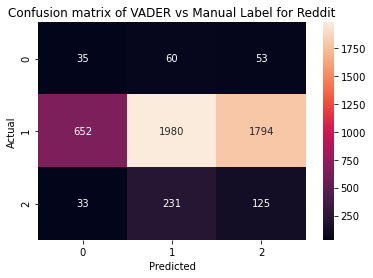

In [14]:
fig = plt.figure()
sns.heatmap(cm, annot = True, fmt='d')
plt.title("Confusion matrix of VADER vs Manual Label for Reddit")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [15]:
accuracy = accuracy_score(y_true, y_pred)
f1Score = f1_score(y_true, y_pred, average='macro')
precisionScore = precision_score(y_true, y_pred, average='macro')
recallScore = recall_score(y_true, y_pred, average='macro')

print("Accuracy: {}%\nF1-score: {}\nPrecision Score: {}\nRecall Score: {}".format(f'{accuracy*100:.2f}', f'{f1Score:.3f}', f'{precisionScore:.3f}', f'{recallScore:.3f}'))

Accuracy: 43.12%
F1-score: 0.259
Precision Score: 0.328
Recall Score: 0.335


# Naive Bayes Classifier

In [16]:
x_train, x_test, y_train, y_test = train_test_split(df[['cleanText']], 
                                                    df['Sentiment'], 
                                                    test_size=0.2, 
                                                    random_state=0)

In [17]:
vectorizer = CountVectorizer(ngram_range=(1,2))
cv = vectorizer.fit_transform(x_train['cleanText'])

In [18]:
clf = MultinomialNB().fit(cv, y_train)

In [19]:
test_vector = vectorizer.transform(x_test['cleanText'])
result = clf.predict(test_vector)
cmNB = metrics.confusion_matrix(y_test, result)
cmNB

array([[  2,  26,   0],
       [  2, 873,   5],
       [  0,  82,   3]])

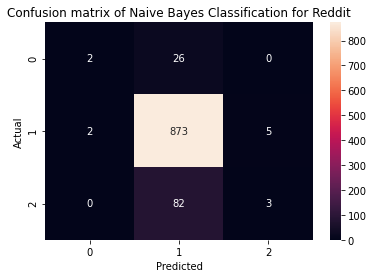

In [20]:
fig = plt.figure()
sns.heatmap(cmNB, annot = True, fmt='d')
plt.title("Confusion matrix of Naive Bayes Classification for Reddit")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [21]:
# count vectorizing with unigram + bigram
accuracy = accuracy_score(y_test, result)
f1Score = f1_score(y_test, result, average='macro')
precisionScore= precision_score(y_test, result, average='macro')
recallScore = recall_score(y_test, result, average='macro')

print("Accuracy: {}%\nF1-score: {}\nPrecision Score: {}\nRecall Score: {}".format(f'{accuracy*100:.2f}', f'{f1Score:.3f}', f'{precisionScore:.3f}', f'{recallScore:.3f}'))

Accuracy: 88.42%
F1-score: 0.376
Precision Score: 0.588
Recall Score: 0.366


# Ensemble Classification
## Random Forest Classification

In [22]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(bootstrap=False,max_features='sqrt',n_estimators=800)

rfCLF = clf.fit(cv, y_train)

test_vector = vectorizer.transform(x_test['cleanText'])
result = clf.predict(test_vector)
cmRF = metrics.confusion_matrix(y_test, result)
cmRF

array([[  2,  26,   0],
       [  5, 869,   6],
       [  0,  80,   5]])

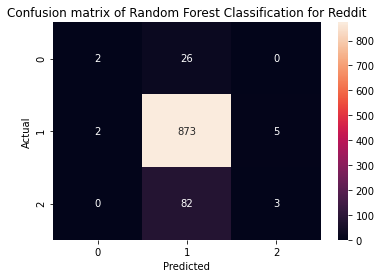

In [23]:
fig = plt.figure()
sns.heatmap(cmNB, annot = True, fmt='d')
plt.title("Confusion matrix of Random Forest Classification for Reddit")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [24]:
# count vectorizing with unigram + bigram
accuracy = accuracy_score(y_test, result)
f1Score = f1_score(y_test, result, average='macro')
precisionScore= precision_score(y_test, result, average='macro')
recallScore = recall_score(y_test, result, average='macro')

print("Accuracy: {}%\nF1-score: {}\nPrecision Score: {}\nRecall Score: {}".format(f'{accuracy*100:.2f}', f'{f1Score:.3f}', f'{precisionScore:.3f}', f'{recallScore:.3f}'))

Accuracy: 88.22%
F1-score: 0.385
Precision Score: 0.544
Recall Score: 0.373


In [25]:
df.to_csv('reddit_dataset.csv')